In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import cv2
import os
import time
from tqdm import tqdm
from torch.utils.data import Dataset
import torch.nn as nn
from PIL import Image


In [6]:
class CelebADataset:
    def __init__(self, folder_path, limit=30000, img_size=128):
        self.img_size = img_size
        self.folder_path = folder_path
        self.file_names = os.listdir(folder_path)[:limit]  # Limit the number of images
        
    def __len__(self):
        return len(self.file_names)
    
    def __getitem__(self, idx):
        img_name = self.file_names[idx]
        img_path = os.path.join(self.folder_path, img_name)
        
        # Load grayscale image
        X = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        X = cv2.resize(X, (self.img_size, self.img_size))
        X = X.astype('float32') / 255.0
        X = X.reshape(1, self.img_size, self.img_size)  # added channel dim
        
        # Load color image
        y = cv2.imread(img_path)[:, :, ::-1]  # BGR to RGB
        y = cv2.resize(y, (self.img_size, self.img_size))
        y = y.astype('float32') / 255.0
        y = y.transpose(2, 0, 1)  # Change to channel-first format
        
        return X, y

# Usage
folder_path = r"D:\Emotion_detection\img_align_celeba"
dataset = CelebADataset(folder_path=folder_path, limit=1000, img_size=128)

In [7]:

# Example: Get first sample
X_sample, y_sample = dataset[0]
print(f"Grayscale image shape: {X_sample.shape}")
print(f"Color image shape: {y_sample.shape}")


Grayscale image shape: (1, 128, 128)
Color image shape: (3, 128, 128)


In [8]:
train_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)
a, b = next(iter(train_loader))
a.shape, b.shape

(torch.Size([64, 1, 128, 128]), torch.Size([64, 3, 128, 128]))

In [9]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.Encoder = nn.Sequential(

            nn.Conv2d(1, 64, (3,3), stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, (3,3), stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, (3,3), stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, (3,3), stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 1024, (3,3), stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(1024),
            nn.MaxPool2d(kernel_size=2, stride=2),

        )

        self.Decoder = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, (3,3), stride=2, padding=1, output_padding=1),
            nn.ReLU(),

            nn.ConvTranspose2d(512, 256, (3,3), stride=2, padding=1, output_padding=1),
            nn.ReLU(),

            nn.ConvTranspose2d(256, 128, (3,3), stride=2, padding=1, output_padding=1),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 64, (3,3), stride=2, padding=1, output_padding=1),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 3, (3,3), stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
    def forward(self, x):
        x = self.Encoder(x)
        x = self.Decoder(x)
        return x



In [10]:
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [11]:
epochs = 2
train_losses = []

for epoch in range(epochs):
    model.train()
    total_epoch_loss = 0

    for gray, col in tqdm(train_loader):

        outputs = model(gray)
        loss = criterion(outputs, col)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_epoch_loss += loss.item()

    avg_loss = total_epoch_loss/len(train_loader)
    print(f"EPOCH: {epoch+1}, LOSS: {avg_loss}")
    train_losses.append(avg_loss)

100%|██████████| 16/16 [11:21<00:00, 42.59s/it]


EPOCH: 1, LOSS: 0.0634213867597282


 19%|█▉        | 3/16 [02:45<11:58, 55.30s/it]


KeyboardInterrupt: 

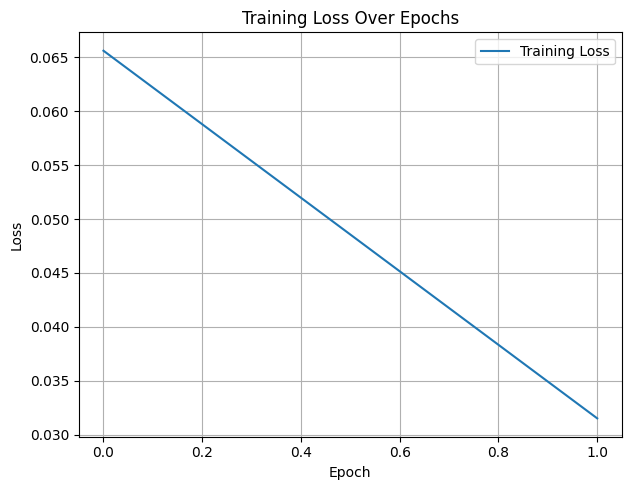

In [ ]:
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

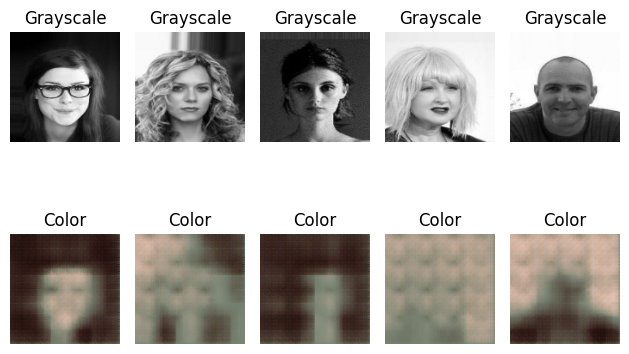

In [ ]:
a, b = next(iter(train_loader))
y_pred = model(a)
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(a[i].reshape((128, 128)), cmap='gray')
    plt.title('Grayscale')
    plt.axis('off')

    plt.subplot(2, 5, i + 6)
    plt.imshow(y_pred[i].detach().numpy().transpose(1, 2, 0))
    plt.title('Color')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
import os
import shutil

# Paths
source_folder = r"D:\Emotion_detection\img_align_celeba"
destination_folder = r"D:\Emotion_detection\celeba_35k"
num_images = 35000

# Create destination folder if it doesn't exist
os.makedirs(destination_folder, exist_ok=True)

# Get all image files from source folder
all_files = [f for f in os.listdir(source_folder) 
             if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

# Ensure we don't exceed available images
num_images = min(num_images, len(all_files))

# Copy first 35k images
for i, filename in enumerate(all_files[:num_images]):
    src_path = os.path.join(source_folder, filename)
    dst_path = os.path.join(destination_folder, filename)
    
    # Copy file
    shutil.copy2(src_path, dst_path)
    
    # Print progress every 1000 files
    if (i+1) % 1000 == 0:
        print(f"Copied {i+1}/{num_images} files")

print(f"\nSuccessfully copied {num_images} images to {destination_folder}")

Copied 1000/35000 files
Copied 2000/35000 files
Copied 3000/35000 files
Copied 4000/35000 files
Copied 5000/35000 files
Copied 6000/35000 files
Copied 7000/35000 files
Copied 8000/35000 files
Copied 9000/35000 files
Copied 10000/35000 files
Copied 11000/35000 files


KeyboardInterrupt: 